## Prepare for the envrioment
Load the libraries and packages

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = '/home/yiyang/github/MD/data/GSE92332_uncompressed/GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '/home/yiyang/github/MD/data/Macosko_cell_cycle_genes.txt'


In [3]:

# Initialize a dataset adatas to store the dataset
adatas = []

for sample, sample_id in zip(sample_strings, sample_id_strings):
    # 解析文件名
    data_file = f"{file_base}{sample_id}{exp_string}{sample}{data_file_end}"
    barcode_file = f"{file_base}{sample_id}{exp_string}{sample}{barcode_file_end}"
    gene_file = f"{file_base}{sample_id}{exp_string}{sample}{gene_file_end}"
    
    # Load data
    adata = sc.read(data_file, cache=True).transpose()
    adata.X = adata.X.toarray()

    barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
    genes = pd.read_csv(gene_file, header=None, sep='\t')

    # Annotate data
    barcodes.rename(columns={0:'barcode'}, inplace=True)
    barcodes.set_index('barcode', inplace=True)
    adata.obs = barcodes
    adata.obs['sample'] = sample
    adata.obs['region'] = sample.split("_")[0]
    adata.obs['donor'] = sample.split("_")[1]

    genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes['gene_symbol'] = genes['gene_symbol'].str.replace('^mm10_', '', regex=True)
    genes.set_index('gene_symbol', inplace=True)
    adata.var = genes

    adata.var_names_make_unique()

    adatas.append(adata)

# combine all the data
adata = adatas[0].concatenate(adatas[1:], batch_key='sample_id')

if 'gene_id-1' in adata.var.columns:
    adata.var['gene_id'] = adata.var['gene_id-1']
    adata.var.drop(columns=['gene_id-1', 'gene_id-0'], inplace=True)

adata.obs.drop(columns=['sample_id'], inplace=True)
adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
adata.obs_names_make_unique(join='_')

print(f"Load data finished. There are {adata.n_obs} cells and  {adata.n_vars} genes.")
adata.write('/home/yiyang/github/MD/data/mouse_intestinal_epithelium.h5ad')


/tmp/ipykernel_760598/1478823044.py:38: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key='sample_id')


数据加载完成。总共有 13353 个细胞和 27998 个基因。


In [4]:
print("region:")
print(adata.obs['region'].value_counts())
print("\n" + "="*50 + "\n")

print("donor:")
print(adata.obs['donor'].value_counts())
print("\n" + "="*50 + "\n")

print("sample:")
print(adata.obs['sample'].value_counts())
print("\n" + "="*50 + "\n")


region:
region
Duo    4554
Jej    4496
Il     4303
Name: count, dtype: int64


donor:
donor
M2    6711
M1    6642
Name: count, dtype: int64


sample:
sample
Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: count, dtype: int64




## Quality control

In [6]:
# Calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
adata.var_names = adata.var_names.str.replace('^mm10_', '', regex=True)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

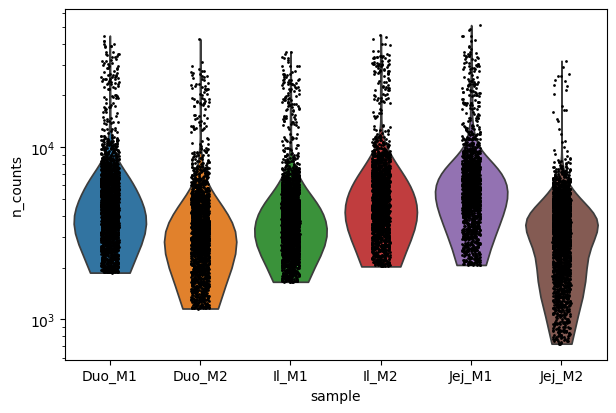

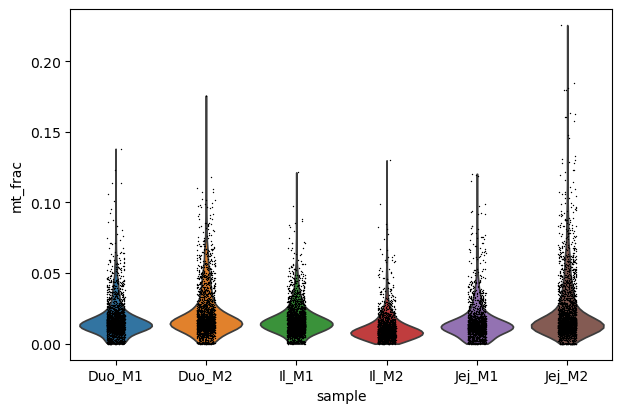

In [8]:
# Plot QC metrics
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

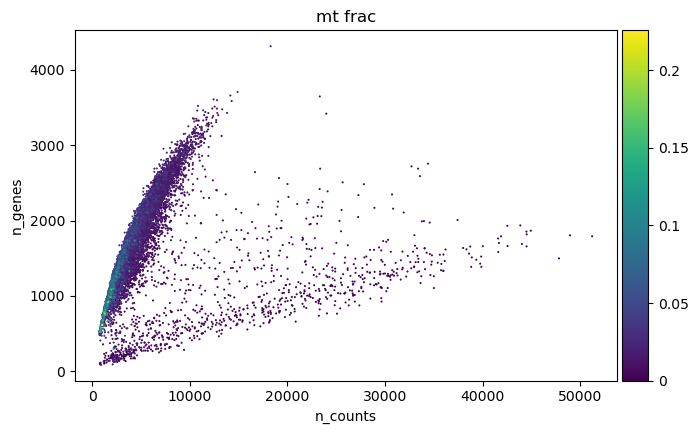

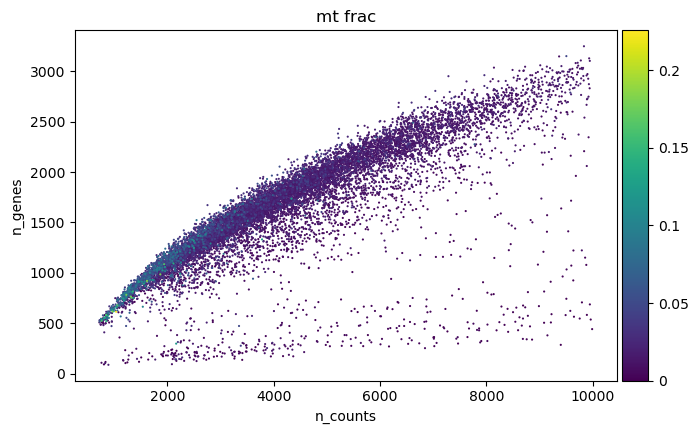

In [9]:
#Data summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

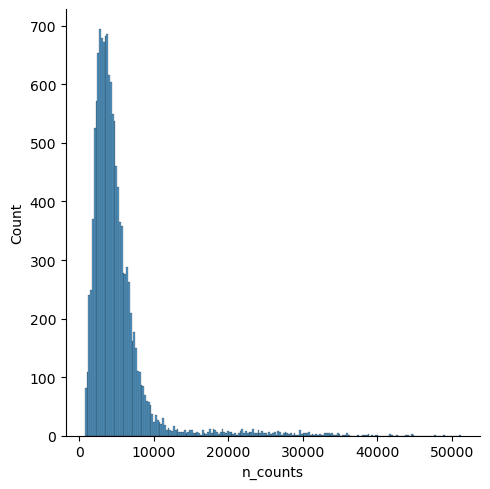

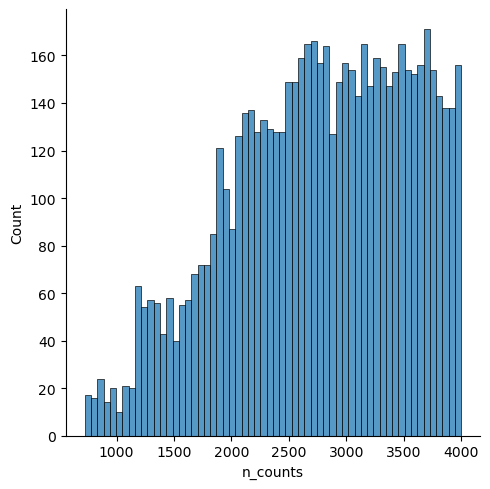

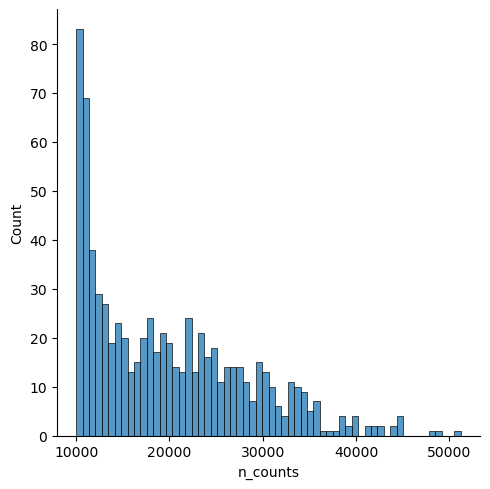

In [11]:
# Thresholding decision: counts
p3 = sb.displot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()